In [1]:
import numpy as np # for maths 
import matplotlib # for plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm # tqdm is a package that lets you make progress bars to see how a loop is going

import os 

import pandas as pd # pandas is a popular library in industry for manipulating large data tables

from astropy.timeseries import LombScargle

# configure notebook for plotting
%matplotlib inline

mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme

# subsequent lines default plot settings
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(8.0,6.0)   
matplotlib.rcParams['font.size']=16              
matplotlib.rcParams['savefig.dpi']= 300             

import warnings
warnings.filterwarnings('ignore')

C:\Users\neha\AppData\Local\Temp\ipykernel_24768\1040310382.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-colorblind') # colourblind-friendly colour scheme


In [42]:
ddir_stars = 'universe_8/' # point this to where you unzip your data!

ddir = ddir_stars + 'Variable_Star_Data/'

In [31]:
fname = 'BackS016089.csv' # put your filename here

data = pd.read_csv(ddir+fname) # load in CSV data as a Pandas object
print(data.keys()) # see what's in it
time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables
dt = np.median(np.diff(time))
print('Nyquist Limit',0.5/dt,'cycles per hour') # can't get frequencies higher than the Nyquist limit

Index(['Time', 'NormalisedFlux'], dtype='object')
Nyquist Limit 0.5 cycles per hour


Text(0, 0.5, 'Relative Flux')

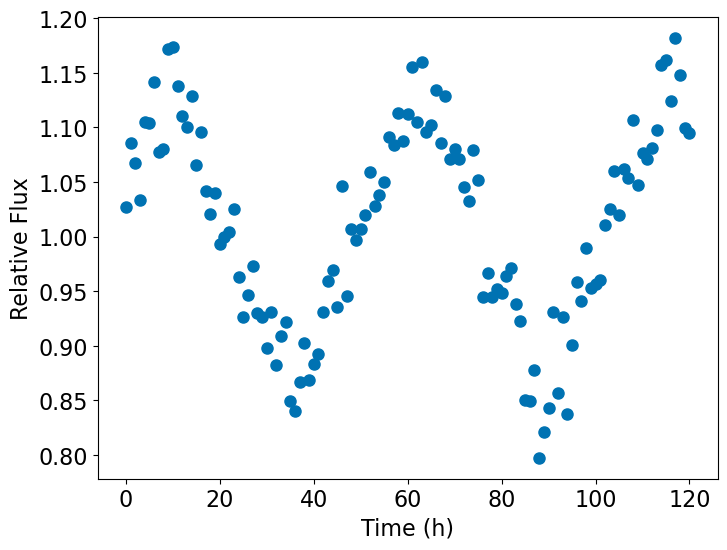

In [32]:
plt.plot(time,flux,'.',markersize=16)
plt.xlabel('Time (h)')
plt.ylabel('Relative Flux')

Lomb-Scargle Periodograms

In [34]:
LS = LombScargle(time,flux) # initialize a Lomb-Scargle algorithm from Astropy
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
power = LS.power(freqs) # calculate LS power 


In [35]:
print('Best period: %.2f h' % (1/freqs[np.argmax(power)]))

Best period: 53.31 h


Text(0, 0.5, 'LS Power')

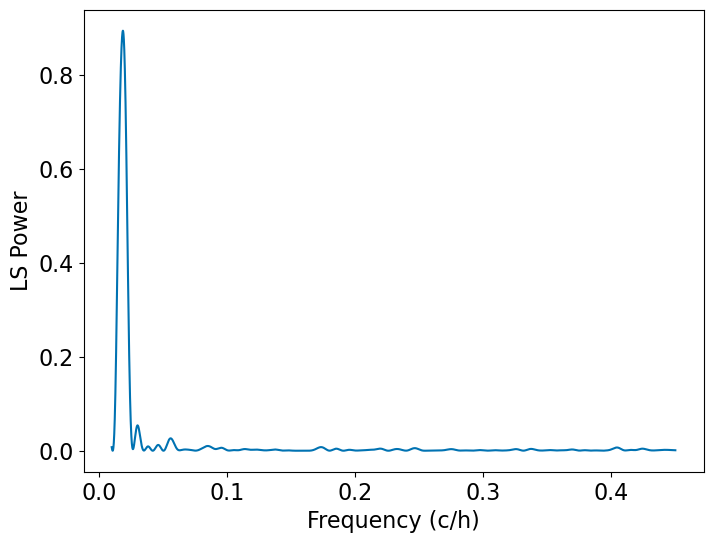

In [36]:
plt.plot(freqs,power)
plt.xlabel('Frequency (c/h)')
plt.ylabel('LS Power')

In [37]:
import glob # this package lets you search for filenames

fnames = glob.glob(ddir+'*.csv')
print(fnames[:10])

['universe_8/Variable_Star_Data\\BackS016039.csv', 'universe_8/Variable_Star_Data\\BackS016052.csv', 'universe_8/Variable_Star_Data\\BackS016058.csv', 'universe_8/Variable_Star_Data\\BackS016070.csv', 'universe_8/Variable_Star_Data\\BackS016089.csv', 'universe_8/Variable_Star_Data\\BackS016091.csv', 'universe_8/Variable_Star_Data\\BackS016134.csv', 'universe_8/Variable_Star_Data\\BackS016239.csv', 'universe_8/Variable_Star_Data\\BackS016296.csv', 'universe_8/Variable_Star_Data\\BackS016439.csv']


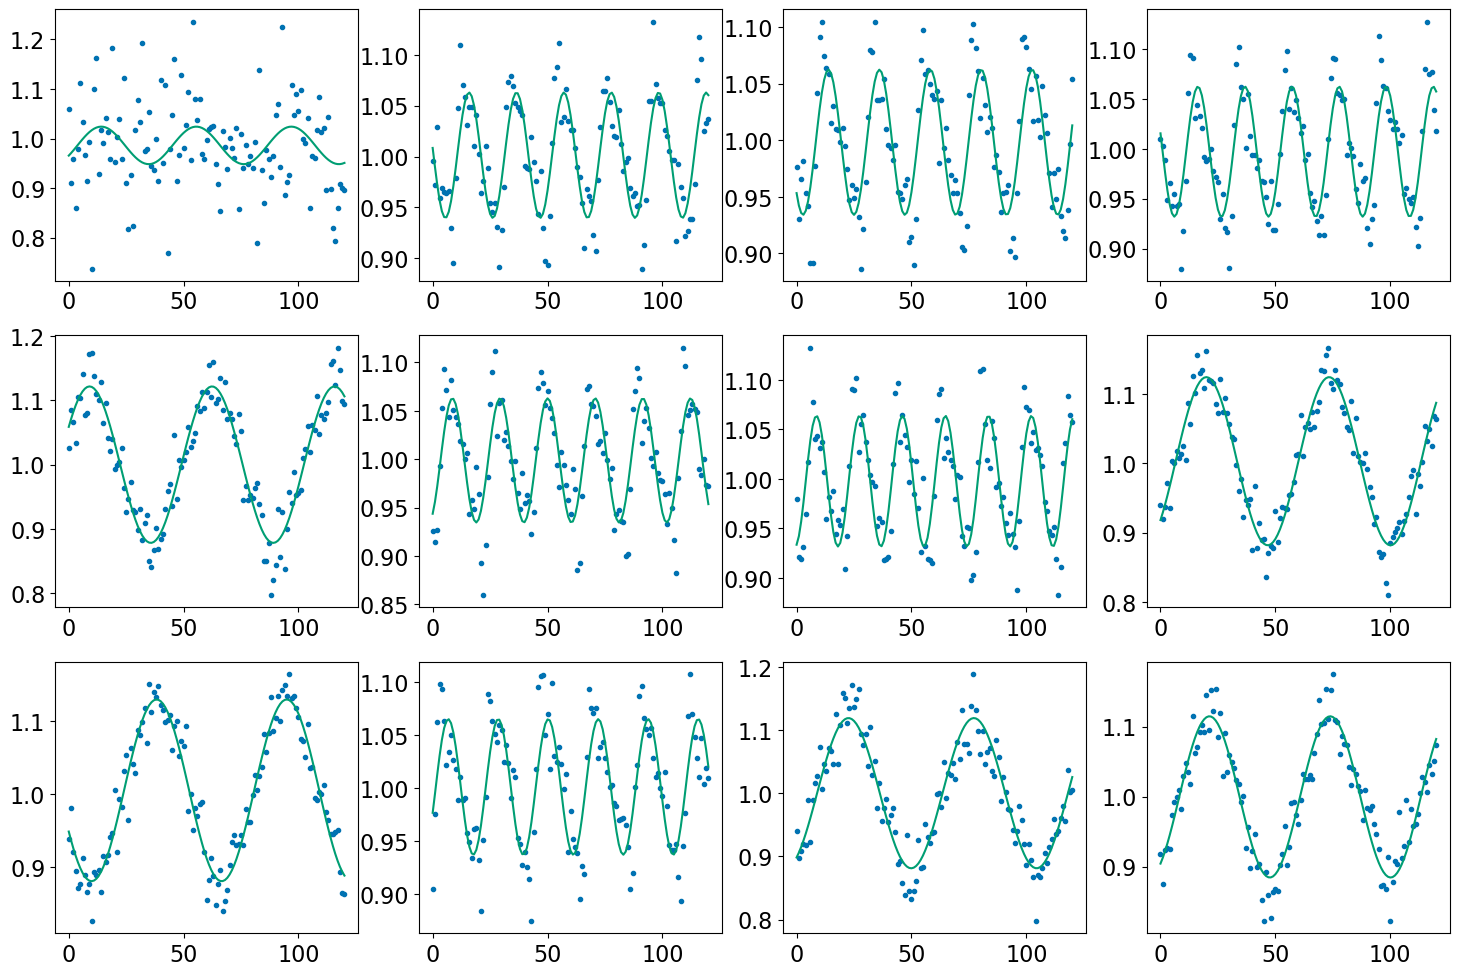

In [43]:
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 

fig, axes = plt.subplots(3,4,figsize=(18,12))
for fname, ax in zip(fnames[:12], axes.ravel()): # you can loop over two things
    data = pd.read_csv(fname) # load in CSV data as a Pandas object

    time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables

    LS = LombScargle(time,flux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    ax.plot(time,flux,'.')
    ax.plot(time,pred) # plot the model over the data
    
    periods.append(1/bestfreq) # add each period to the list
    
periods = np.array(periods) # turn it from a list to an array

In [47]:
freqs = np.linspace(1/100,0.45,10000) # frequency grid shouldn't go higher than Nyquist limit
periods = [] # start an empty list to hold the period 
names = []

for fname in tqdm(fnames): # tqdm is a package that gives you a progress bar - neat! 
    data = pd.read_csv(fname) # load in CSV data as a Pandas object

    time, flux = data.Time, data.NormalisedFlux # just extract the columns as variables

    LS = LombScargle(time,flux) # initialize a Lomb-Scargle
    power = LS.power(freqs) # calculate LS power 
    bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
    
    pred = LS.model(time,bestfreq) # make a sine wave prediction at the best frequency
    
    periods.append(1/bestfreq) # add each period to the list
    names.append(os.path.basename(fname).strip('.csv')) # os.path.basename gets rid of directories and gives you the filename; then we strip '.csv'
    
periods = np.array(periods) # turn it from a list to an array

  0%|          | 2/3360 [00:00<07:15,  7.70it/s]

100%|██████████| 3360/3360 [05:23<00:00, 10.37it/s]


In [48]:
import glob # this package lets you search for filenames
import os
print(names)
print(periods)
variables = pd.DataFrame({'Name':names,
              'Period':periods}) # you can turn a dictionary into a dataframe like this

variables.Name = variables.Name.astype('|S') # have to do this so that it knows the names are strings

all_star_files = glob.glob(ddir_stars+'*/Star_Data.csv')


all_stars = pd.concat([pd.read_csv(table) for table in all_star_files]) # we are concatenating a list of dataframes; 
#we generate this list with a "list comprehension", a loop you write inside a list bracket 

all_stars.Name = all_stars.Name.astype('|S') # have to do this so that it knows the names are strings
all_stars = all_stars[all_stars.Parallax > 0.01] # 10 mas parallax cut
print(len(all_stars),'stars above 10 mas parallax') # check how many stars there are total with good parallax

variables = pd.merge(all_stars,variables,on='Name') # merge these two arrays according to the keyword 'name'
print('Of which',len(variables),'variables') # cut down to a small list


['BackS016039', 'BackS016052', 'BackS016058', 'BackS016070', 'BackS016089', 'BackS016091', 'BackS016134', 'BackS016239', 'BackS016296', 'BackS016439', 'BackS016466', 'BackS016602', 'BackS016873', 'BackS017073', 'BackS017102', 'BackS017175', 'BackS017368', 'BackS017385', 'BackS017403', 'BackS017490', 'BackS017573', 'BackS017587', 'BackS017657', 'BackS017758', 'BackS017774', 'BackS017913', 'BackS018015', 'BackS018048', 'BackS018154', 'BackS018318', 'BackS018383', 'BackS018533', 'BackS018606', 'BackS018610', 'BackS018617', 'BackS018654', 'BackS018678', 'BackS018698', 'BackS018699', 'BackS018727', 'BackS018734', 'BackS018742', 'BackS018763', 'BackS018775', 'BackS018777', 'BackS018799', 'BackS018821', 'BackS018826', 'BackS018831', 'BackS018843', 'BackS018846', 'BackS018848', 'BackS018878', 'BackS018886', 'BackS018908', 'BackS018911', 'BackS018916', 'BackS018920', 'BackS018935', 'BackS018951', 'BackS018953', 'BackS018988', 'BackS018992', 'BackS018993', 'BackS019038', 'BackS019040', 'BackS019

In [49]:
m0, m1, m2 = np.log10(all_stars['BlueF']), np.log10(all_stars['GreenF']), np.log10(all_stars['RedF']) 
colour = m2-m0
abs_mag = m1 + 2*np.log10(1./all_stars.Parallax) 

v0, v1, v2 = np.log10(variables['BlueF']), np.log10(variables['GreenF']), np.log10(variables['RedF']) 
variable_colour = v2-v0
abs_mag_v = v1 + 2*np.log10(1./variables.Parallax) 


Text(0.5, 0, 'Log Flux 2 - Log Flux 0')

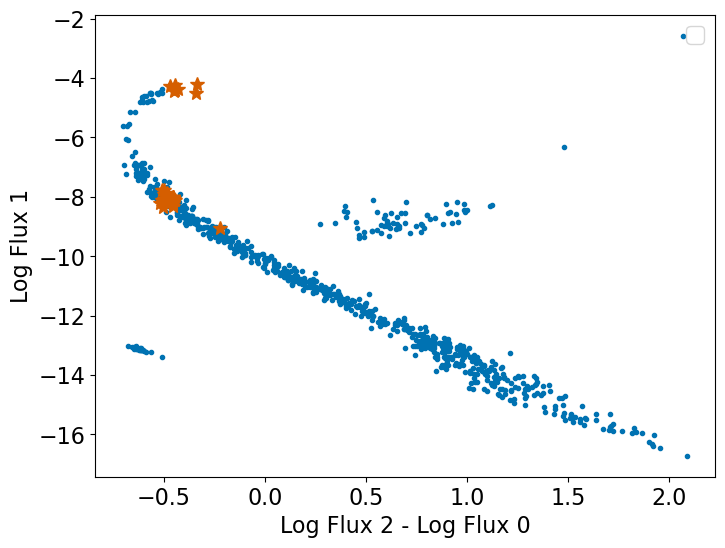

In [50]:
s = plt.plot(colour,abs_mag,'.C0')
h = plt.plot(variable_colour,abs_mag_v,'.C2',marker='*',markersize=10)

    
plt.legend([s, h],['Steady','Variable'])
plt.ylabel('Log Flux 1')
plt.xlabel('Log Flux 2 - Log Flux 0')

Text(0, 0.5, 'Log Flux')

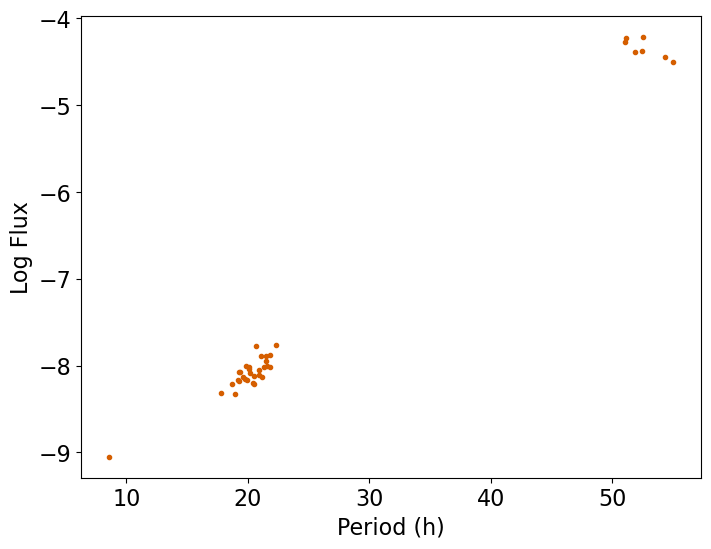

In [51]:
plt.plot(variables.Period,abs_mag_v,'.',color='C2')
plt.xlabel('Period (h)')
plt.ylabel('Log Flux')